# Análise de sentimento com reviews da Amazon

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [2]:
# Lendo a base de dados e criando uma amostra

df = pd.read_csv('Reviews.csv')

print(df.shape)

df = df.sample(frac=1)
df = df.head(1000)

print(df.shape)

(568454, 10)
(1000, 10)


In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
67487,67488,B001I8BOBW,A28MUV7ZYLZ1OP,Marie,0,0,5,1323820800,Use it for half Cafe,I am a HUGE coffee drinker on a budget with go...
37800,37801,B000LKVDO6,AZWRZZAMX90VT,Rennie,0,0,5,1246320000,Comfort food,The texture of this is like lumpy mashed potat...
215468,215469,B0014X5O1C,A2W0XCWOK3MW6F,"Karen Woodworth Roman ""Happy Librarian""",1,1,5,1209081600,Yum!,"IZZE All Natural Sparkling Juice, Clementine i..."
426984,426985,B00434FU36,A1PSTI5G8UP5W1,ToxMox,2,2,5,1305763200,We love these in our house!,I was first introduced the the Old El Paso Gor...
179480,179481,B000CQC050,A2FDEV3OLZNJ19,Susan Brown,1,1,5,1233792000,Apple Cinnamon Tea is great,I don't drink American teas so I special order...


In [4]:
df['Text'].values[0]

'I am a HUGE coffee drinker on a budget with gormet taste.  I cannot drink caffenated coffee all day like people in their 20\'s.  I had to find a compromise.  Also, I am addicted to Chocolate Rhaspberry Coffee. Won\'t drink anything else.  Soooooooo  I found a de-cafe that works great with my gormet coffee.  1/2 Folgers, which is not bitter, harsh or overpowering, and 1/2 my Chocolate Rhaspberry.  Been doing it for years now.  Have 2 of these delivered every 2 months on Amazon\'s "Subscribe and Save" and get great \'guaranteed\' pricing and free shipping.  Can\'t beat it .<br /><br />This is a great coffee straight or if you go half and half like I do.'

## Análise exploratória

Text(0.5, 0, 'Review das estrelas')

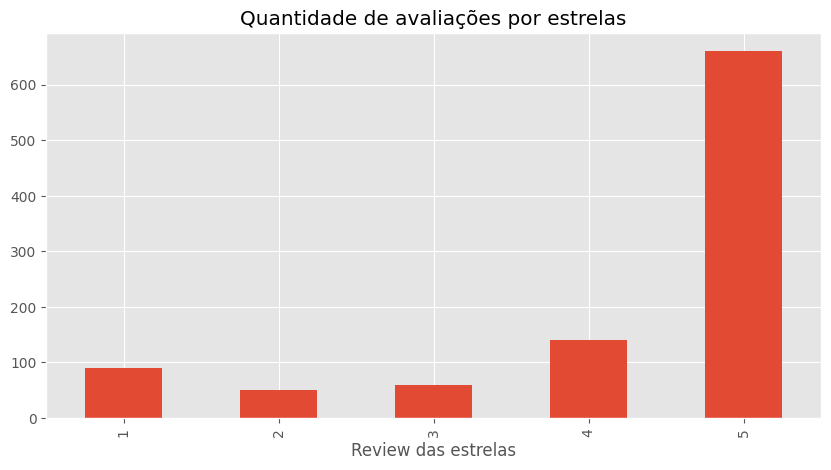

In [5]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Quantidade de avaliações por estrelas',
          figsize=(10, 5))
ax.set_xlabel('Review das estrelas')


## NLTK

In [6]:
example = df['Text'].values[40]
print(example)

This is the perfect combination of caramel and chocolate. The chocolate has a really smooth consistency and they've added just the right amount of caramel to go with it. I like these much better than Caramello bars.


In [7]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This',
 'is',
 'the',
 'perfect',
 'combination',
 'of',
 'caramel',
 'and',
 'chocolate',
 '.']

In [8]:
# Cada token da frase recebeu uma classe gramatical

tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('is', 'VBZ'),
 ('the', 'DT'),
 ('perfect', 'JJ'),
 ('combination', 'NN'),
 ('of', 'IN'),
 ('caramel', 'NN'),
 ('and', 'CC'),
 ('chocolate', 'NN'),
 ('.', '.')]

In [9]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  is/VBZ
  the/DT
  perfect/JJ
  combination/NN
  of/IN
  caramel/NN
  and/CC
  chocolate/NN
  ./.
  The/DT
  chocolate/NN
  has/VBZ
  a/DT
  really/RB
  smooth/JJ
  consistency/NN
  and/CC
  they/PRP
  've/VBP
  added/VBN
  just/RB
  the/DT
  right/JJ
  amount/NN
  of/IN
  caramel/NN
  to/TO
  go/VB
  with/IN
  it/PRP
  ./.
  I/PRP
  like/IN
  these/DT
  much/RB
  better/JJR
  than/IN
  (PERSON Caramello/NNP)
  bars/NNS
  ./.)


## VADER

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [11]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [12]:
sia.polarity_scores('I am so sad!')

{'neg': 0.648, 'neu': 0.352, 'pos': 0.0, 'compound': -0.5697}

In [13]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.779, 'pos': 0.221, 'compound': 0.8442}

#### Executar a pontuação de escolaridade para o dataset completo

In [14]:
#O "tqdm" entra dentro do for para criar uma barra de acompanhamento
resultados = {}

for index, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    resultados[myid] = sia.polarity_scores(text)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
vaders = pd.DataFrame(resultados).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [16]:
# Agora temos a pontuação de polaridade junto com a base original
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,67488,0.000,0.733,0.267,0.9855,B001I8BOBW,A28MUV7ZYLZ1OP,Marie,0,0,5,1323820800,Use it for half Cafe,I am a HUGE coffee drinker on a budget with go...
1,37801,0.000,0.853,0.147,0.6124,B000LKVDO6,AZWRZZAMX90VT,Rennie,0,0,5,1246320000,Comfort food,The texture of this is like lumpy mashed potat...
2,215469,0.041,0.771,0.187,0.9373,B0014X5O1C,A2W0XCWOK3MW6F,"Karen Woodworth Roman ""Happy Librarian""",1,1,5,1209081600,Yum!,"IZZE All Natural Sparkling Juice, Clementine i..."
3,426985,0.029,0.798,0.173,0.9963,B00434FU36,A1PSTI5G8UP5W1,ToxMox,2,2,5,1305763200,We love these in our house!,I was first introduced the the Old El Paso Gor...
4,179481,0.059,0.765,0.176,0.9031,B000CQC050,A2FDEV3OLZNJ19,Susan Brown,1,1,5,1233792000,Apple Cinnamon Tea is great,I don't drink American teas so I special order...


### Plotando os resultados do Vader

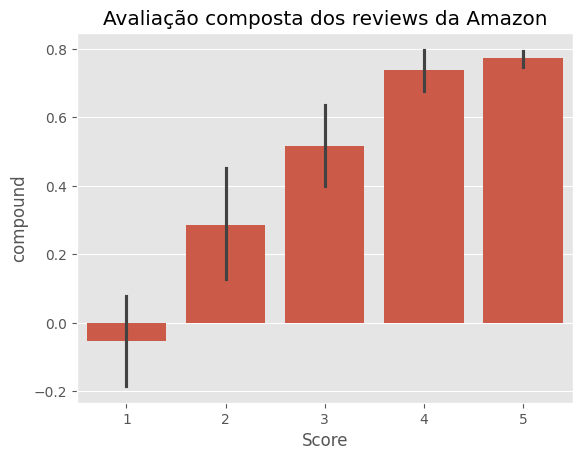

In [17]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Avaliação composta dos reviews da Amazon')
plt.show()

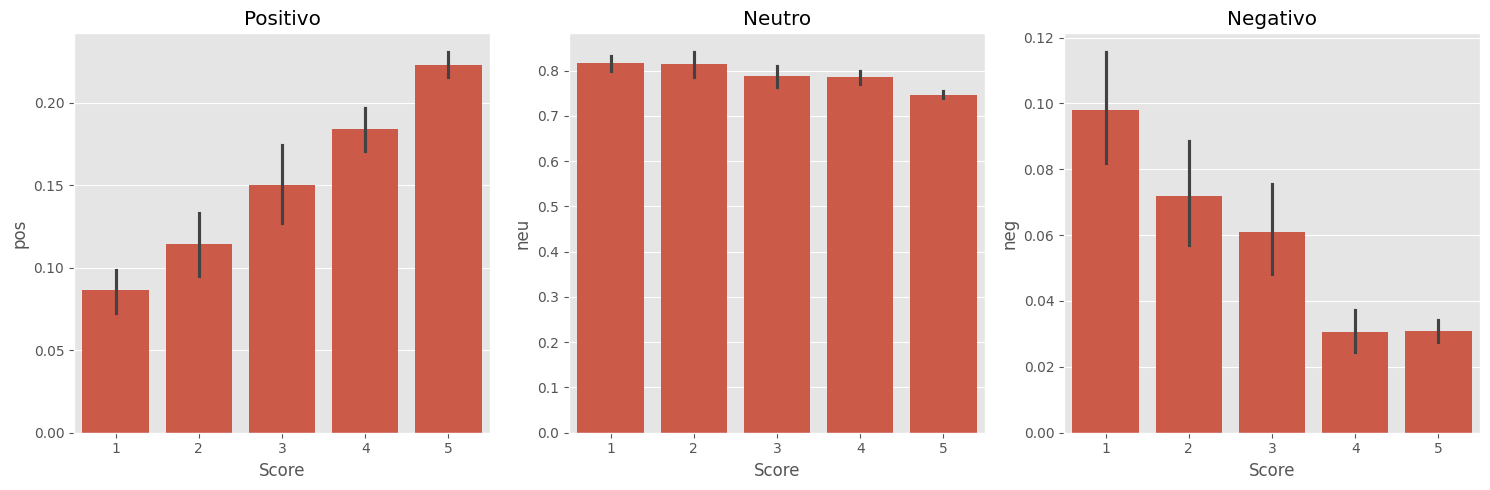

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=vaders, x='Score', y='pos', ax = axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax = axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax = axs[2])
axs[0].set_title('Positivo')
axs[1].set_title('Neutro')
axs[2].set_title('Negativo')
plt.tight_layout()
plt.show()

## RoBERTa

In [19]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [20]:
modelo = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(modelo)
model = AutoModelForSequenceClassification.from_pretrained(modelo)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
# Relembrando o resultado do VADER na variável de exemplo

print(example)
sia.polarity_scores(example)

This is the perfect combination of caramel and chocolate. The chocolate has a really smooth consistency and they've added just the right amount of caramel to go with it. I like these much better than Caramello bars.


{'neg': 0.0, 'neu': 0.779, 'pos': 0.221, 'compound': 0.8442}

In [22]:
# Preparando a variável para aplicar o modelo RoBERTa

def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [23]:
resultados = {}

for index, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)

        vader_result_rename={}
        for key, value in vader_result.items():
            vader_result_rename[f'vader_{key}'] = value

        roberta_result = polarity_scores_roberta(text)
        dois_resultados = {**vader_result_rename, **roberta_result}
        resultados[myid] = dois_resultados
    except RuntimeError:
        print(f'Erro gerado por conta do id {myid}')
   

  0%|          | 0/1000 [00:00<?, ?it/s]

Erro gerado por conta do id 374361
Erro gerado por conta do id 249909
Erro gerado por conta do id 223705
Erro gerado por conta do id 162578
Erro gerado por conta do id 140014
Erro gerado por conta do id 324242
Erro gerado por conta do id 109084
Erro gerado por conta do id 465405
Erro gerado por conta do id 396158


In [24]:
dois_resultados

{'vader_neg': 0.0,
 'vader_neu': 0.687,
 'vader_pos': 0.313,
 'vader_compound': 0.9601,
 'roberta_neg': 0.31597456,
 'roberta_neu': 0.44519216,
 'roberta_pos': 0.2388333}

In [25]:
df_resultados = pd.DataFrame(resultados).T
df_resultados = df_resultados.reset_index().rename(columns={'index': 'Id'})
df_resultados = df_resultados.merge(df, how='left')

In [26]:
df_resultados.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,67488,0.000,0.733,0.267,0.9855,0.099460,0.304062,0.596478,B001I8BOBW,A28MUV7ZYLZ1OP,Marie,0,0,5,1323820800,Use it for half Cafe,I am a HUGE coffee drinker on a budget with go...
1,37801,0.000,0.853,0.147,0.6124,0.008296,0.044870,0.946834,B000LKVDO6,AZWRZZAMX90VT,Rennie,0,0,5,1246320000,Comfort food,The texture of this is like lumpy mashed potat...
2,215469,0.041,0.771,0.187,0.9373,0.003668,0.093131,0.903201,B0014X5O1C,A2W0XCWOK3MW6F,"Karen Woodworth Roman ""Happy Librarian""",1,1,5,1209081600,Yum!,"IZZE All Natural Sparkling Juice, Clementine i..."
3,426985,0.029,0.798,0.173,0.9963,0.003705,0.041200,0.955095,B00434FU36,A1PSTI5G8UP5W1,ToxMox,2,2,5,1305763200,We love these in our house!,I was first introduced the the Old El Paso Gor...
4,179481,0.059,0.765,0.176,0.9031,0.006089,0.057542,0.936369,B000CQC050,A2FDEV3OLZNJ19,Susan Brown,1,1,5,1233792000,Apple Cinnamon Tea is great,I don't drink American teas so I special order...


## Comparando os Scores entre os modelos

In [27]:
df_resultados.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

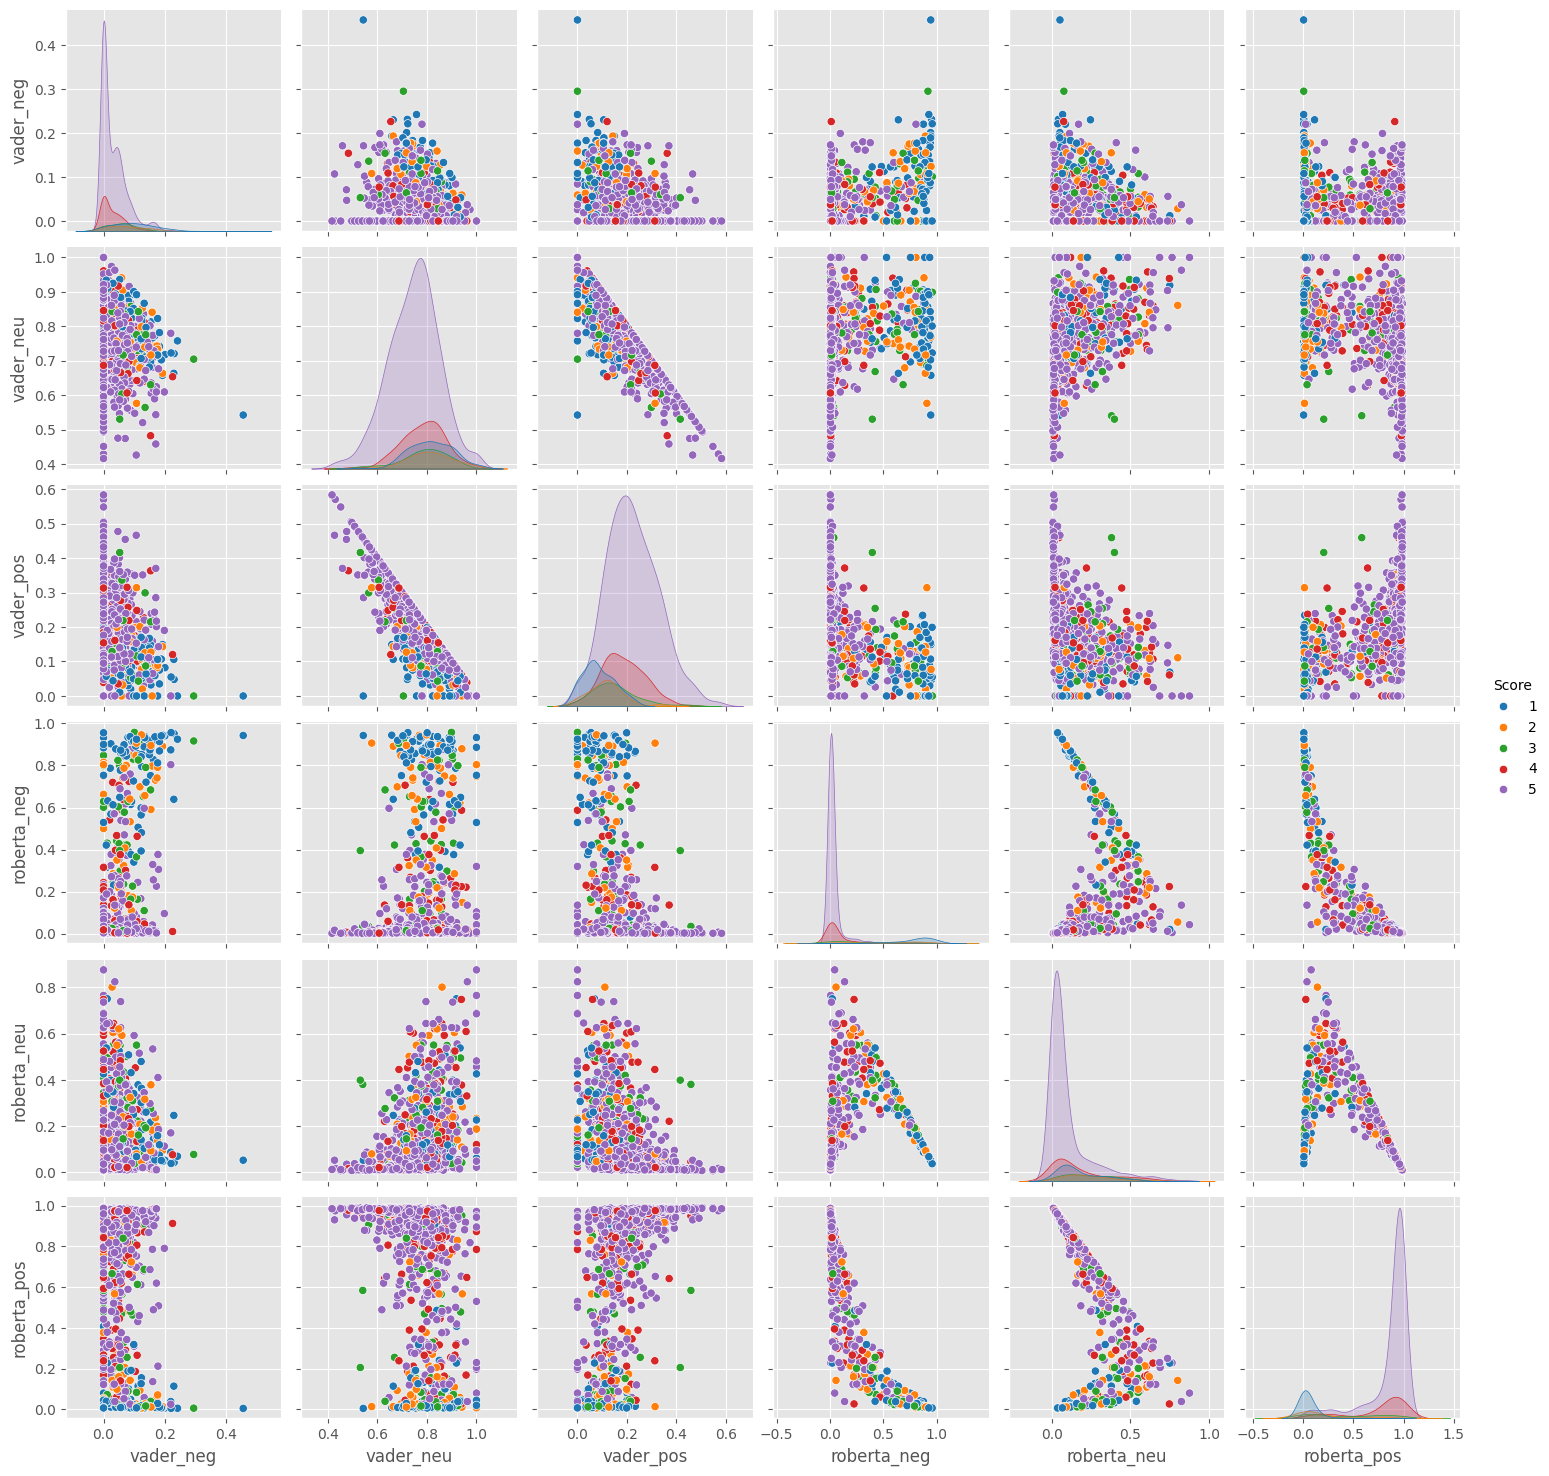

In [28]:
sns.pairplot(data=df_resultados,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                   'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue='Score',
            palette='tab10')

plt.show()

## Analisando casos positivos de 1 estrela e casos negativos de 5 estrelas

In [29]:
df_resultados.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'I love these.  I mean, I really love them.  And I was about to order them, but out of curiosity glanced down at the reviews.<br /><br />Mrs. May, I hope you read these reviews!  I will be one of your faithful customers forever if you start making these in the US.<br /><br />I choose not to buy any products (especially food) made in China, because of 2 concerns: 1.  Human rights issues and the use of prisoners as unpaid laborers (this is why the price is cheap on Chinese-made goods) and 2.  Concerns for quality control.'

In [30]:
df_resultados.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'though i did not purchase this through amazon, i did get this recently from thw grocery store, and have to admit im really disappointed.  i followed the instructions the first evening EXACTLY as instructed with the included paper, and no results.  the second day, i brewed just a little longer, still no luck, (basing this off some other comments from other users here on amazon) then today i only did 6oz, not 12 as the paper instructs, and even brewed this for 6 minutes.  still nothing.<br /><br />i really wanted this to work for me like it has for others, i had heard good things and was so excited, but still no luck.  i guess im one of those people this doesnt affect. ill keep trying it daily till i run out, but looks like ill have to try something else.<br /><br />as for taste, its not bad. just tastes like tea leaves, not deliciously fantastic, but not nose-pinchingly undrinkable. good luck to anyone else. hope you have more success with this than i did'

In [31]:
df_resultados.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

"I would never pay the fortune being asked to have it shipped!  The shipping cost alone is DOUBLE the cost of the tea itself!  How does a gallon jug of tea translate into a shipping weight of 10 pounds?  It's madness!  What's even more crazy is that I happen to live very close to where this tea is produced and bottled (Cincinnati, OH) and for some reason, it's even difficult to find around here!  The TradeWinds company must have a really poor marketing and distribution staff because, despite all the products the company supposedly makes, I can only find their jugs of Sweet Tea very occasionally.  This area should be SATURATED with their products, and yet I never see their stuff anywhere around here.  If you are not in an area where you can find this tea brand at a local store (and good luck!) I suggest you just make your own at home.  I mean, come on!  It's TEA!"

In [32]:
df_resultados.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'All coffee flavor , unlike the other weird tasting non-caffeinated coffees.<br />I hate the "acidic taste " that most others have.<br /><br />Try it and you\'ll see what you have been missing.'

## Transformers Pipeline

In [33]:
from transformers import pipeline

sent_pipeline = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [34]:
sent_pipeline('I love you')

[{'label': 'POSITIVE', 'score': 0.9998656511306763}]

In [35]:
sent_pipeline('I hate you')

[{'label': 'NEGATIVE', 'score': 0.9991129040718079}]

In [36]:
example = df['Text'].values[37]
teste = polarity_scores_roberta(example)

In [37]:
teste

{'roberta_neg': 0.010464257,
 'roberta_neu': 0.099263005,
 'roberta_pos': 0.89027274}

In [59]:

151
example = df['Text'].values[350]
analise_sent = polarity_scores_roberta(example)
analise_sent_vader = sia.polarity_scores(example)


print('Resultado VADER')
print(example)
print(analise_sent_vader)
print('')
print('Resultado RoBERTa')
print(example)
print(teste)



Resultado VADER
The gummies are great.  I bought them 4 my mom and she ate them up.  The product arrived quickly and in good condition.
{'neg': 0.0, 'neu': 0.731, 'pos': 0.269, 'compound': 0.7906}

Resultado RoBERTa
The gummies are great.  I bought them 4 my mom and she ate them up.  The product arrived quickly and in good condition.
{'roberta_neg': 0.010464257, 'roberta_neu': 0.099263005, 'roberta_pos': 0.89027274}
